# 最適輸送理論を用いた人物ラベル判定


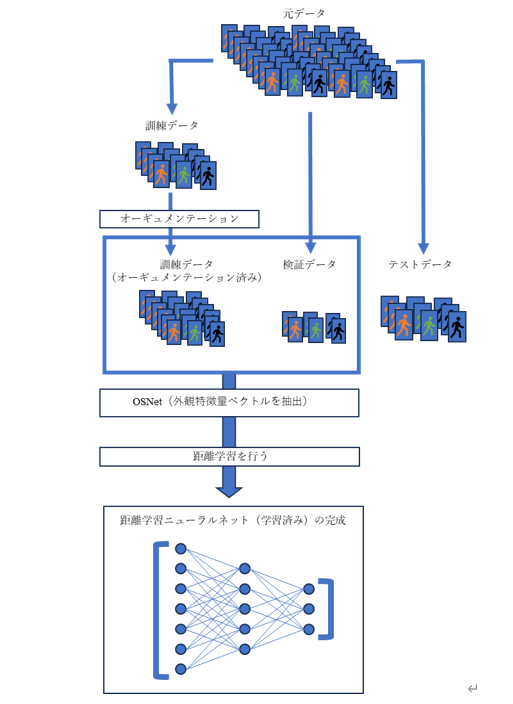


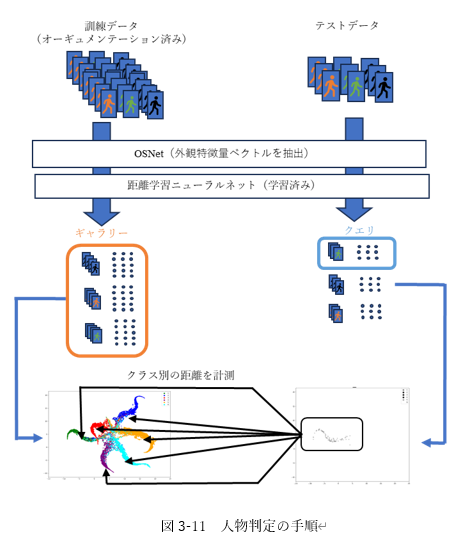



file_pathを複数設定しているが，csvファイルを出力する必要がなければ，dfでコードを止めてもよい

入力：
- file_path0(クエリデータのためのテストデータ，'original_point_ID'を追加)この処理をしないと，同一のpoint_IDに複数の異なるトラクレットが含まれる．例えば，point5のトラクレット102とpoint6のトラクレット102が同一となる．そこで5_102と6_102とすることで二つのトラクレットを区別している
- file_path1（ギャラリーデータのための訓練データ）
- file_path2（クエリデータのためのテストデータ，file_path0で加工したもの）

出力：
- excel_path
  - original_point_ID
  - Predicted_label(Distance_label_〇が最も小さいラベルを予測ラベルとする)
  - True_label
  - size（クエリであるトラクレットに含まれるサンプル数）
  - Distance_label_0
  - Distance_label_1
  - Distance_label_2
  - Distance_label_3
  - Distance_label_4
  - Distance_label_5
  - Distance_label_6

- report_file_path
  - 混同行列
  - f1スコア
 
### 最適輸送理論

- 距離定義：コサイン類似度（サンプル間の距離が小さいほど，コスト関数も小さくなる必要があるので，1-cosin_similarityとしている）
- 重み一定（a,b）

In [ ]:
import numpy as np
import pandas as pd
import ot
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

def split_by_point_id(df):
    unique_point_ids = df['original_point_ID'].unique()
    split_data = {}

    for point_id in unique_point_ids:
        filtered_df = df[df['original_point_ID'] == point_id]
        split_data[point_id] = {
            'data': filtered_df,
            'labels': filtered_df['label'].tolist()
        }

    return split_data

# コサイン類似度行列を計算する関数
def cosine_similarity_matrix(matrix1, matrix2):
    return cosine_similarity(matrix1, matrix2)

###############################################################################################

##サンプルを区分するための新しい，列を生成する
# ファイルのパス
file_path0 ="C:/Users/sugie/PycharmProjects/pythonProject10/orient_tranceformed_data/tranceformed_data_all_orient5_num_metric_arc_norm_OSNetMed3_without_point5_koizumi_b.csv"

# ファイルを読み込む
df0 = pd.read_csv(file_path0, dtype={'label': str, 'point_ID': str})


chunk_size = 10000
chunks = []
for chunk in pd.read_csv(file_path0, chunksize=chunk_size):
    # ファイル名をアンダースコアで分割して最後の部分を取得
    last_part = chunk['file_name'].str.split('_').str[-1]

    # 最初の文字を取得
    first_character = last_part.str[5]

    # original_point_IDの作成
    chunk['original_point_ID'] = (
            chunk['label'].astype(str) + "_" +
            chunk['point_ID'].astype(str) + "_" +
            chunk['file_name'].str.split('_').str[0].fillna('') + "_" +
            first_character
    )

    chunks.append(chunk)

df0 = pd.concat(chunks, ignore_index=True)


# 出力ファイルのパス
output_file_path ="C:/Users/sugie/PycharmProjects/pythonProject10/orient_tranceformed_data/tranceformed_data_all_orient5_num_metric_arc_norm_OSNetMed3_without_point5_koizumi_b.csv"

# 新しいデータフレームをCSVファイルとして保存
df1.to_csv(output_file_path, index=False)

##################################################################################################################

# 1つ目のCSVファイルの正確なパス(ギャラリーデータのための訓練データ)
file_path_1 = "C:/Users/sugie/PycharmProjects/pythonProject10/orient_tranceformed_data/tranceformed_data_all_orient5_num_metric_arc_norm_OSNetMed3_with_point5_koizumi.csv"
df1 = pd.read_csv(file_path_1)

# ラベル1から6のサンプル数を取得
min_sample_count = df1[df1['label'].isin([1, 2, 3, 4, 5, 6])]['label'].value_counts().min()

# ラベル0のサンプルを抽出
label_0_samples = df1[df1['label'] == 0]

# ラベル0のサンプルの数をラベル1から6の最小のサンプル数のn倍にランダムサンプリング
sampled_label_0 = label_0_samples.sample(n=min_sample_count * 1, random_state=42)

# ランダムサンプリングしたデータを元のデータフレームに戻す
df1 = pd.concat([df1[df1['label'] != 0], sampled_label_0])

# 2つ目のCSVファイルの正確なパス（クエリデータのためのテストデータ）
file_path_2 = "C:/Users/sugie/PycharmProjects/pythonProject10/orient_tranceformed_data/tranceformed_data_all_orient5_num_metric_arc_norm_OSNetMed3_without_point5_koizumi_b.csv"
df2 = pd.read_csv(file_path_2)


# point_IDごとにデータフレームを分割
split_dataframes = split_by_point_id(df2)

labels = [0, 1, 2, 3, 4, 5, 6]
correct_count = 0  # 正答数
results_data = []  # 結果を保存するためのリスト

distances = {}
label_correct_count = {label: 0 for label in labels}

for point_ID, data in split_dataframes.items():
    df2 = data['data']
    df2_size = len(df2)

    distances = {}  # 各ラベルに対する最適輸送距離を保存する辞書

    for label in labels:
        # 特定のラベルに対応する行を選択し、特徴量を取得
        label_data_1 = df1[df1.iloc[:, 0] == label]
        label_features_1 = label_data_1.iloc[:, 7:].values
        vector_train = label_features_1

        label_features_2 = df2.iloc[:, 7:-1].values
        vector_test = label_features_2

        # # 各ベクトルのノルムを計算
        # norms_train = np.linalg.norm(vector_train, axis=1)
        # norms_test = np.linalg.norm(vector_test, axis=1)

        # コサイン類似度に基づくコスト行列を計算
        C_cosine = 1 - cosine_similarity_matrix(vector_train, vector_test)

        # 最終的なコスト行列を計算
        C = C_cosine

        a = np.ones(len(vector_train)) / len(vector_train)
        b = np.ones(len(vector_test)) / len(vector_test)

        # 最適輸送問題の解決
        result = ot.emd(a, b, C)
        transport_distance = np.sum(result * C)
        distances[label] = transport_distance
        print(f"Optimal transport distance for label {label}: {transport_distance}")

    answer_label = min(distances, key=distances.get)
    true_label = df2['label'].unique()[0]
    print(df2.shape[0])

    # 正答数をカウント
    if answer_label == true_label:
        correct_count += 1
        label_correct_count[true_label] += 1  # 正答数をラベルごとにカウント
    print(f"Expected label for point_ID {point_ID}: {true_label}")
    print(f"Predicted label for point_ID {point_ID}: {answer_label}")
    print("-" * 50)

    # 結果データに予測ラベル、実際のラベル、各ラベルの距離を追加
    result_entry = {
        "original_point_ID": point_ID,
        "Predicted_label": answer_label,
        "True_label": true_label,
        "size": df2_size
    }
    result_entry.update({f"Distance_label_{label}": distances[label] for label in labels})
    results_data.append(result_entry)

accuracy = correct_count / len(split_dataframes) * 100
print(f"Accuracy: {accuracy:.2f}%")

# 結果をDataFrameに変換
results_df = pd.DataFrame(results_data)

# DataFrameをExcelファイルに書き出す
excel_path = "C:/Users/sugie/PycharmProjects/pythonProject10/orient_result/result_dim128_orient_OSNet_triplet_point5.xlsx"  # 書き出すパスを指定
results_df.to_excel(excel_path, index=False)

# True labels と Predicted labels を格納するリスト
true_labels = []
predicted_labels = []
for result in results_data:
    true_labels.append(result["True_label"])
    predicted_labels.append(result["Predicted_label"])

# 既存のclassification_reportを出力
report_dict = classification_report(true_labels, predicted_labels, target_names=[str(label) for label in labels], output_dict=True)

# ラベル0とその他のグループ分け
binary_true_labels = ['0' if label == 0 else 'その他' for label in true_labels]
binary_predicted_labels = ['0' if label == 0 else 'その他' for label in predicted_labels]

# confusion_matrixを計算
conf_matrix = confusion_matrix(binary_true_labels, binary_predicted_labels, labels=['0', 'その他'])

# 混同行列を表示
print("Confusion Matrix for Label 0 vs Others:")
print(conf_matrix)

# confusion_matrixをDataFrameに変換してラベル付け
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True_0', 'True_その他'], columns=['Pred_0', 'Pred_その他'])
print(conf_matrix_df)

# ラベル0とその他に対するclassification_reportを計算
binary_report_dict = classification_report(binary_true_labels, binary_predicted_labels, target_names=['0', 'その他'], output_dict=True)

# フォーマットされたレポート文字列を作成
formatted_report = ""

# 既存のラベルごとのレポートを追加
formatted_report += "\n=== 各ラベルごとの結果 ===\n"
for label, metrics in report_dict.items():
    if isinstance(metrics, dict):
        formatted_report += f"\nLabel: {label}\n"
        for metric, value in metrics.items():
            formatted_report += f"  {metric}: {value:.4f}\n"
    else:
        formatted_report += f"{label}: {metrics:.4f}\n"

# ラベル0とその他のグループ分けに対するレポートを追加
formatted_report += "\n=== ラベル0とその他の結果 ===\n"
for label, metrics in binary_report_dict.items():
    if isinstance(metrics, dict):
        formatted_report += f"\nLabel: {label}\n"
        for metric, value in metrics.items():
            formatted_report += f"  {metric}: {value:.4f}\n"
    else:
        formatted_report += f"{label}: {metrics:.4f}\n"

# コンソールに出力
print(formatted_report)

# レポートをファイルに書き出す
report_file_path = "C:/Users/sugie/PycharmProjects/pythonProject10/reports/classification_report_OSNet_triplet_point5_with_binary_count.txt"
with open(report_file_path, 'w') as file:
    file.write("Confusion Matrix:\n")
    file.write(conf_matrix_df.to_string())
    file.write("\n\n")
    file.write(formatted_report)